In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np

In [ ]:
code_dir=Path.cwd()
project_dir=code_dir.parent
input_dir=project_dir/"input"
output_dir=project_dir/"output/roiwise_prediction_saturation"
tmp_dir=project_dir/"tmp"

output_dir.mkdir(exist_ok=True)

In [ ]:
prediction_df = pd.read_csv(input_dir/"prediction_df.csv")

schaefer_labels = pd.read_csv(input_dir/f"atlases/edited_Schaefer400Parcels7Networks_labels.txt", delim_whitespace=True).columns.to_list()
hcp1065_labels = pd.read_csv(input_dir/f"atlases/HCP1065_labels.txt", delim_whitespace=True, header=None, index_col=0).index.to_list()
tian_labels = pd.read_csv(input_dir/f"atlases/Tian_Subcortex_S1_3T_label.txt", delim_whitespace=True, header=None, index_col=0).index.to_list()

In [ ]:
base_variables = ["Age","sex_int", "Education"]

lesion_data_modalities = ["sLNM", "fLNM", 
    "roiWMH", "WMHvolume"]

subj_list = prediction_df.index.tolist()

# Prediction

In [ ]:
from sklearn.metrics import make_scorer

from julearn.scoring import register_scorer
import scipy

def pearson_scorer(y_pred, y_true):
    return scipy.stats.pearsonr(y_pred, y_true)[0]

register_scorer(scorer_name='pearsonr', scorer=make_scorer(pearson_scorer))

In [ ]:
import julearn
import sklearn

print(julearn.__version__)
print(sklearn.__version__)

0.3.0
1.3.2


In [ ]:
from julearn import run_cross_validation
from julearn.utils import configure_logging
from julearn.pipeline import PipelineCreator
from julearn.model_selection import RepeatedContinuousStratifiedKFold

configure_logging(level="ERROR")

# Ridge regression

In [ ]:
scores_dict = {}
model_dict = {}
inspector_dict = {}
result_df = pd.DataFrame()
train_score_df = pd.DataFrame()

In [ ]:
analysis_name = "ridge_confounds"
scoring = ["pearsonr", "explained_variance"]
cv = RepeatedContinuousStratifiedKFold(n_bins=10, method="binning", n_splits=10, n_repeats=10, random_state=42) #RepeatedKFold(n_splits=4, n_repeats=1, random_state=42)


search_params = {
    "kind": "grid",
}

for frac in np.arange(0.2,1.01,0.01):


    for cognitive_domain in clinical_variables:
        
        print(frac)

        X_all = []


        pipeline1 = PipelineCreator(problem_type="regression")
        pipeline1.add("zscore")
        pipeline1.add("ridge",
                    alpha = np.logspace(-3, 3, 7),
                    name="model",
        )


        prediction_df_metric = prediction_df.dropna(subset=[cognitive_domain] + base_variables)
        if frac != 1: prediction_df_metric = prediction_df_metric.sample(frac=frac, random_state=42)

        key = f"{analysis_name}_{cognitive_domain}"
        scores_dict[key], model_dict[key], inspector_dict[key] = run_cross_validation(
            X=base_variables, y=cognitive_domain, data=prediction_df_metric,
            model=[pipeline1], cv = cv, return_estimator='all',
            scoring=scoring, return_train_score=True,search_params=search_params,
            return_inspector= True, n_jobs=15)
        
        result_df.loc[analysis_name, f"{str(int(frac *100))}%_{cognitive_domain}"] = scores_dict[key]["test_pearsonr"].mean(axis=0)
        train_score_df.loc[analysis_name, f"{str(int(frac *100))}%_{cognitive_domain}"] = scores_dict[key]["train_pearsonr"].mean(axis=0)

        pipeline1 = PipelineCreator(problem_type="regression")
        pipeline1.add("zscore")
        pipeline1.add("ridge",
                    alpha = np.logspace(-3, 3, 7),
                    name="model",
        )

        for modality in lesion_data_modalities:
            
            modality_styled = modality.replace("_", "-")
            search_string = f"{modality}"
            X = [col for col in prediction_df.columns if search_string in col]
            X_all.append(X)

            prediction_df_metric = prediction_df.dropna(subset=[cognitive_domain] + base_variables + X)
            if frac != 1: prediction_df_metric = prediction_df_metric.sample(frac=frac, random_state=42)

            key = f"{analysis_name}_{modality}-plus-confounds_{cognitive_domain}"
            scores_dict[key], model_dict[key], inspector_dict[key] = run_cross_validation(
                X=base_variables + X, y=cognitive_domain, data=prediction_df_metric,
                model=[pipeline1], cv = cv, return_estimator='all',
                scoring=scoring, return_train_score=True,search_params=search_params,
                return_inspector= True, n_jobs=15)
            result_df.loc[f"{modality}-plus-confounds_multimodel", f"{str(int(frac *100))}%_{cognitive_domain}"] = scores_dict[key]["test_pearsonr"].mean(axis=0)
            train_score_df.loc[f"{modality}-plus-confounds_multimodel", f"{str(int(frac *100))}%_{cognitive_domain}"] = scores_dict[key]["train_pearsonr"].mean(axis=0)

        X_all = list(set([item for sublist in X_all for item in sublist]))

        X_all_nowmh = list(set([item for item in X_all if "WMH" not in item]))
        
        print(X_all_nowmh)


        prediction_df_metric = prediction_df.dropna(subset=[cognitive_domain] + base_variables + X_all_nowmh)
        if frac != 1: prediction_df_metric = prediction_df_metric.sample(frac=frac, random_state=42)

        key = f"{analysis_name}_all-no-wmh-plus-confounds_{cognitive_domain}"
        scores_dict[key], model_dict[key], inspector_dict[key] = run_cross_validation(
            X=base_variables + X_all_nowmh, y=cognitive_domain, data=prediction_df_metric, 
            model=[pipeline1], cv = cv, return_estimator='all',
            scoring=scoring, return_train_score=True,search_params=search_params,
            return_inspector= True, n_jobs=15)
        result_df.loc[f"all-no-wmh-plus-confounds_multimodel", f"{str(int(frac *100))}%_{cognitive_domain}"] = scores_dict[key]["test_pearsonr"].mean(axis=0)
        train_score_df.loc[f"all-no-wmh-plus-confounds_multimodel", f"{str(int(frac *100))}%_{cognitive_domain}"] = scores_dict[key]["train_pearsonr"].mean(axis=0)

In [239]:
result_df

,20%_attention,20%_ips,20%_language,20%_verbal_memory,21%_attention,21%_ips,21%_language,21%_verbal_memory,22%_attention,22%_ips,...,98%_language,98%_verbal_memory,99%_attention,99%_ips,99%_language,99%_verbal_memory,100%_attention,100%_ips,100%_language,100%_verbal_memory
ridge_confounds,0.351969,0.244910,0.378859,0.330421,0.347465,0.242486,0.419024,0.333620,0.341938,0.237324,...,0.405696,0.305824,0.310416,0.239614,0.404681,0.305844,0.311587,0.238919,0.402862,0.305631
sLNM-plus-confounds_multimodel,0.338702,0.218890,0.284770,0.347290,0.338472,0.233431,0.294116,0.347822,0.322220,0.225263,...,0.379561,0.400077,0.399718,0.309376,0.379416,0.405954,0.399194,0.312650,0.380516,0.405131
fLNM-plus-confounds_multimodel,0.309159,0.278862,0.300484,0.357617,0.312003,0.288622,0.246973,0.380590,0.323463,0.279132,...,0.396259,0.395738,0.392983,0.313160,0.397906,0.395082,0.398756,0.314433,0.398216,0.395300
roiWMH-plus-confounds_multimodel,0.398426,0.183194,0.376137,0.351448,0.379287,0.181768,0.419402,0.354180,0.370592,0.176222,...,0.421458,0.363761,0.363014,0.247216,0.419155,0.363588,0.365090,0.254150,0.417479,0.363768
WMHvolume-plus-confounds_multimodel,0.361727,0.255624,0.377504,0.348359,0.356365,0.252554,0.415818,0.351551,0.350536,0.246744,...,0.405505,0.325751,0.339329,0.250432,0.404969,0.326505,0.340775,0.249152,0.402849,0.326833
all-no-wmh-plus-confounds_multimodel,0.327931,0.292081,0.205107,0.323957,0.345759,0.290946,0.184347,0.348353,0.343331,0.290346,...,0.378958,0.412379,0.405844,0.315268,0.383214,0.413285,0.410761,0.318766,0.383789,0.413230


In [ ]:
# Function to extract percentage as an integer
def extract_percentage(col_name):
    percentage_part = col_name.split('_')[0]
    return int(percentage_part.rstrip('%'))

# Sorting the columns based on the extracted percentage
sorted_columns = sorted(result_df.columns, key=extract_percentage)

# Reordering the DataFrame columns
result_df_sorted = result_df[sorted_columns]
train_score_df_sorted = train_score_df[sorted_columns]

In [55]:
result_df_melt = pd.melt(result_df_sorted.reset_index(), id_vars="index", value_vars=result_df_sorted.columns.tolist())
result_df_melt["percentage"] = result_df_melt["variable"].str.split("%").str[0]
result_df_melt["variable"] = result_df_melt["variable"].str.split("%_").str[1]

result_df_melt_train = pd.melt(train_score_df_sorted.reset_index(), id_vars="index", value_vars=train_score_df_sorted.columns.tolist())
result_df_melt_train["percentage"] = result_df_melt_train["variable"].str.split("%").str[0]
result_df_melt_train["variable"] = result_df_melt_train["variable"].str.split("%_").str[1]

In [56]:
cognitive_domain_styling_dict = {
    "attention":"Attention / Executive function",
    "ips":"Information processing speed",
    "language": "Language",
    "verbal_memory":"Verbal memory"
}

feature_set_styling_dict = {
    'ridge_confounds':"Confounds (age, sex and education)",
    'WMHvolume-plus-confounds_multimodel':"WMH volume + confounds",
    'roiWMH-plus-confounds_multimodel':"Tract-level WMH volumes + confounds",
    'sLNM-plus-confounds_multimodel':"sLNM + confounds",
    'fLNM-plus-confounds_multimodel':"fLNM + confounds",
    'all-no-wmh-plus-confounds_multimodel':"sLNM + fLNM + confounds"
}    


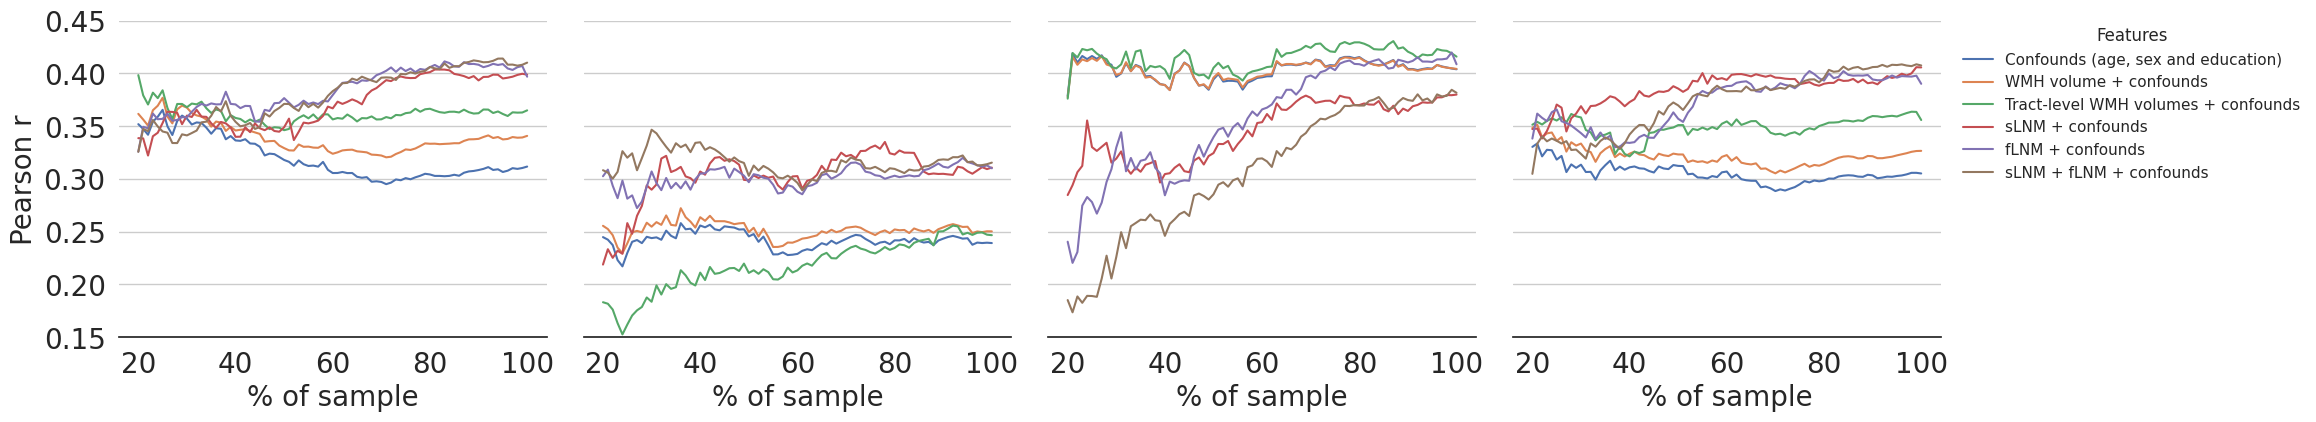

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_context("notebook", font_scale=1)

fontsize1=20
fontsize2=18

plotting_df = result_df_melt.copy()

plotting_df["index"] = plotting_df["index"].replace(feature_set_styling_dict)
plotting_df["variable"] = plotting_df["variable"].replace(cognitive_domain_styling_dict)

order = ["ridge_confounds", "WMHvolume-plus-confounds_multimodel", "roiWMH-plus-confounds_multimodel", "sLNM-plus-confounds_multimodel", "fLNM-plus-confounds_multimodel", "all-no-wmh-plus-confounds_multimodel"]
plotting_df["index"] = pd.Categorical(plotting_df["index"], feature_set_styling_dict.values())

g = sns.FacetGrid(plotting_df, col="variable", hue="index", col_wrap=4, sharey=True, palette="deep")
g.map(sns.lineplot, "percentage", "value")
g.fig.set_size_inches(20, 5)

g.add_legend(title='Features', bbox_to_anchor=(1, 0.7), frameon=False)

plt.grid(visible=True, axis="y")
sns.despine(left=True)

for idx,ax in enumerate(g.axes.flat):
    xticks = ax.get_xticks()
    ax.set_xticks(np.linspace(xticks[0], xticks[-1], 5))
    yticks = ax.get_yticks()
    ax.set_yticks(np.linspace(yticks[0], yticks[-1], 8))
    ax.yaxis.grid(True)
    ax.set_ylim(0.15, 0.45)
    if idx == 0: 
        ax.tick_params(labelleft=True)
        ax.tick_params(axis="y", labelsize=fontsize1)

g.set_axis_labels("% of sample", "Pearson r", fontsize=fontsize1)
g.set_xticklabels(fontsize=fontsize1)
#g.set_yticklabels(fontsize=fontsize1)

g.set_titles("")

plt.savefig(output_dir/f"saturation_plot.png", dpi=300, bbox_inches='tight')
plt.show()
